In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import matplotlib.cm as cm
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint 
from scipy import stats
import yfinance as yf

import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Russell 2000 and S&P 400 
russell_df = yf.download('^RUT', start = '1900-01-01', end = '2023-01-18', progress = False)
sp400_df = yf.download('^SP400', start = '1900-01-01', end = '2023-01-18', progress = False)

In [3]:
russell = russell_df[['Close']]
Russell = russell.rename(columns = {'Close': 'Russell_Close'})

sp400 = sp400_df[['Close']]
Sp400 = sp400.rename(columns = {'Close': 'SP400_Close'})

prices = pd.concat([Russell, Sp400], axis = 1)
prices = prices.dropna()
prices.head()

,Russell_Close,SP400_Close
Date,,
1987-09-10,168.970001,90.000000
1987-09-11,170.539993,90.820000
1987-09-14,170.429993,90.910004
1987-09-15,169.199997,90.290001
1987-09-16,168.919998,90.010002


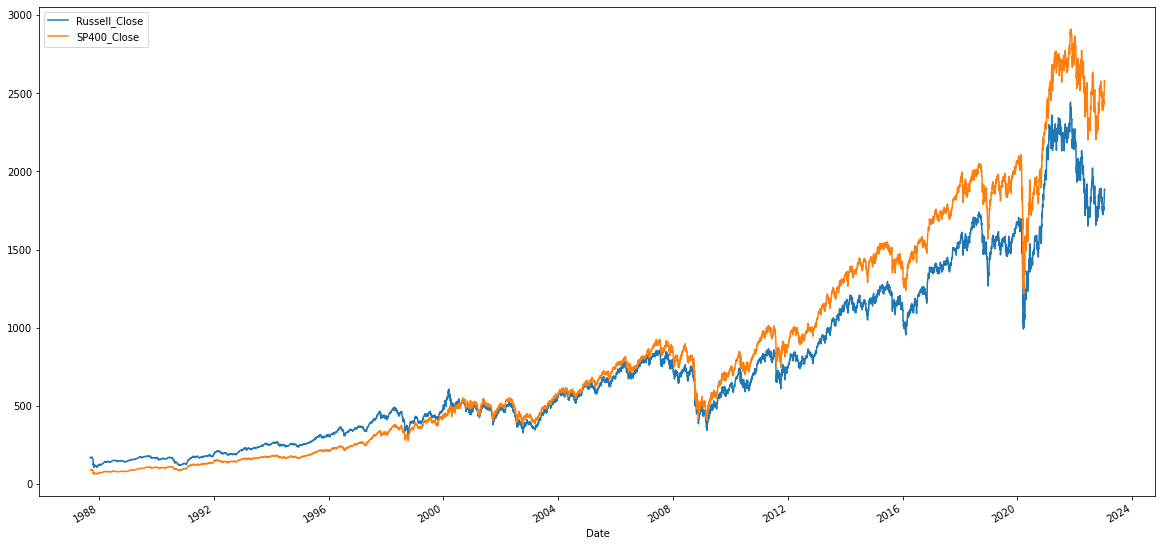

In [4]:
prices.plot(figsize=(20,10));

In [5]:
price_1 = prices['Russell_Close']
price_2 = prices['SP400_Close']


In [6]:
def data_preparation(prices, price_1, price_2, days, num):
    
    obs_mat = np.vstack([price_2, np.ones(price_2.shape)]).T[:, np.newaxis]
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                            initial_state_mean=np.zeros(2),
                            initial_state_covariance=np.ones((2, 2)),
                            transition_matrices=np.eye(2),
                            observation_matrices=obs_mat,
                            observation_covariance=1.0,
                            transition_covariance=trans_cov)
    state_means, state_covs = kf.filter(price_1)
    spread = np.zeros(np.size(price_1))
    slope = np.zeros(np.size(price_1))
    intercept = np.zeros(np.size(price_1))
    variance = np.zeros(np.size(price_1))
    
    for i in range(np.size(spread)):
        spread[i] = price_1[i] - state_means[i, 0] * price_2[i] - state_means[i, 1]
        slope[i] = state_means[i,0]
        intercept[i] = state_means[i,1]
        
    prices['Spread'] = spread
    prices['Slope'] = slope
    prices['Intercept'] = intercept
    prices['Moving_Average'] = prices['Spread'].rolling(days).mean()
    prices['Std'] = prices['Spread'].rolling(days).std()  
    prices.dropna(inplace = True)
    prices['BBand_Lower'] = prices['Moving_Average'] - prices['Std'] * num
    prices['BBand_Upper'] = prices['Moving_Average'] + prices['Std'] * num
    
    return prices

In [7]:
data_preparation(prices, price_1, price_2, 20, 0.7)


,Russell_Close,SP400_Close,Spread,Slope,Intercept,Moving_Average,Std,BBand_Lower,BBand_Upper
Date,,,,,,,,,
1987-10-07,168.869995,91.160004,-0.603904,1.838726,1.855672,-0.239617,0.384145,-0.508519,0.029284
1987-10-08,167.059998,90.339996,-0.683712,1.836264,1.855629,-0.274823,0.391260,-0.548705,-0.000941
1987-10-09,166.119995,89.669998,-0.297538,1.835195,1.855612,-0.291319,0.384523,-0.560485,-0.022152
1987-10-12,163.860001,88.610001,-0.465038,1.833534,1.855585,-0.306958,0.384930,-0.576409,-0.037507
1987-10-13,164.139999,89.239998,-1.012590,1.829864,1.855533,-0.349627,0.413898,-0.639356,-0.059898
...,...,...,...,...,...,...,...,...,...
2023-01-10,1822.650024,2514.520020,0.145269,0.724165,1.577759,-0.005795,0.089157,-0.068205,0.056615
2023-01-11,1844.050049,2545.360107,-0.011797,0.723860,1.577772,-0.008880,0.088190,-0.070614,0.052853
2023-01-12,1876.060059,2568.370117,0.225724,0.729746,1.577590,-0.000105,0.102027,-0.071524,0.071314


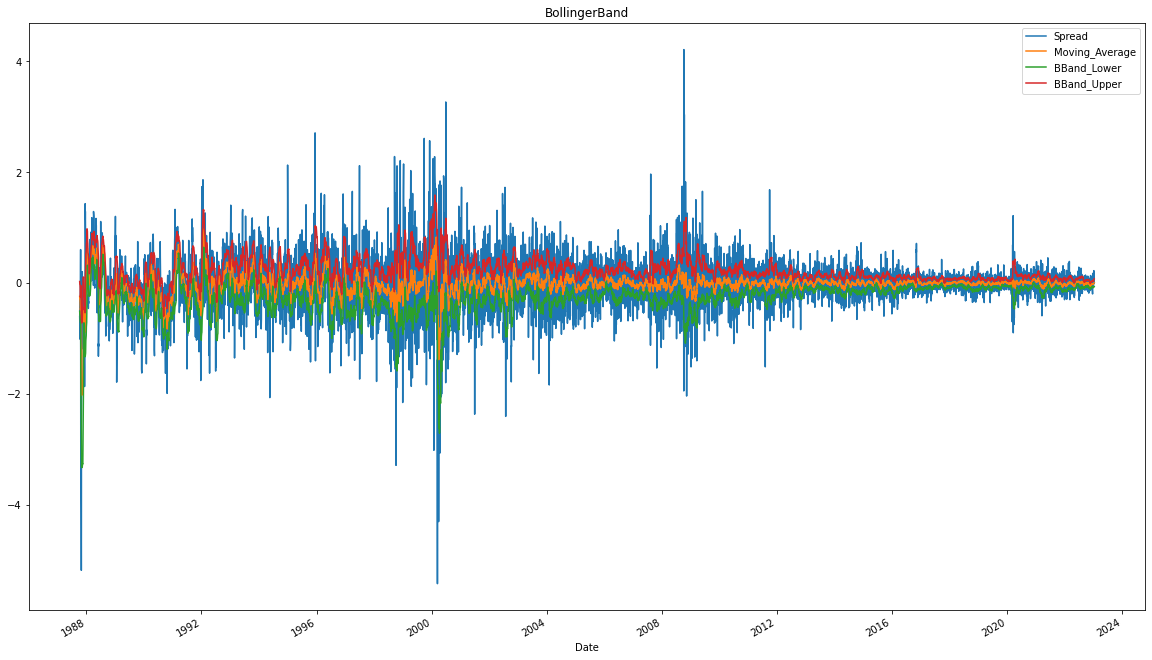

In [8]:
prices[['Spread','Moving_Average', 'BBand_Lower', 'BBand_Upper']].plot(figsize=(20,12), title = 'BollingerBand');

In [9]:
S = 0.1 # stop_loss
prices['position_1'] = np.where(prices['Spread'] > prices['BBand_Upper'], -1, np.nan)
prices['position_1'] = np.where(prices['Spread'] < prices['BBand_Lower'], 1, prices['position_1'])
prices['position_1'] = np.where(abs((prices['Spread'] - prices['Moving_Average']) / prices['Std']) < S, 0, prices['position_1'])
prices['position_1'] = prices['position_1'].fillna(method='ffill')
prices.dropna(inplace = True)
prices['position_2'] = - np.sign(prices['position_1'])

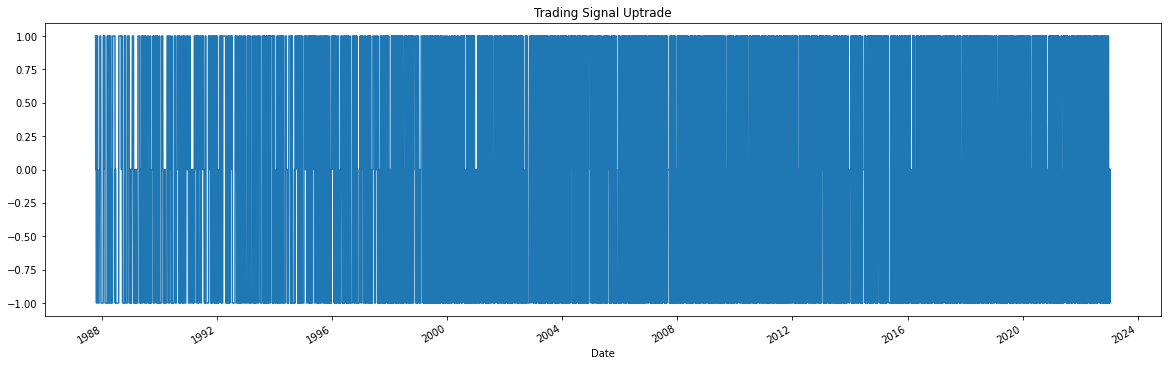

In [10]:
prices['position_1'].plot(ylim = [-1.1, 1.1], figsize = (20,6), title = 'Trading Signal Uptrade');

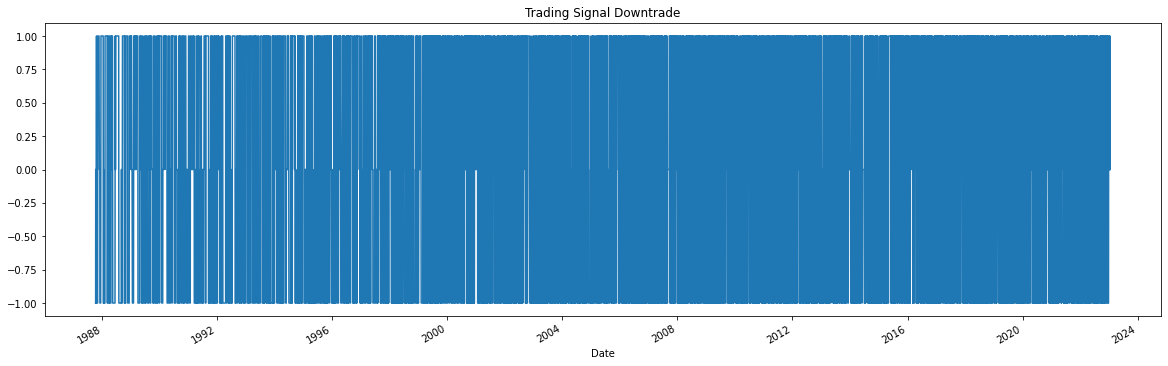

In [11]:
prices['position_2'].plot(ylim = [-1.1, 1.1], figsize = (20,6), title = 'Trading Signal Downtrade');

In [12]:
prices['returns_1'] = np.log(prices['Russell_Close'] / prices['Russell_Close'].shift(1))
prices['returns_2'] = np.log(prices['SP400_Close'] / prices['SP400_Close'].shift(1))
prices['weight'] = prices['Intercept'] / (1+prices['Intercept'])
prices['strategy'] = prices['weight'] * (prices['position_1'].shift(1) * prices['returns_1']) + (1-prices['weight']) * (prices['position_2'].shift(1) * prices['returns_2'])

In [13]:
prices

,Russell_Close,SP400_Close,Spread,Slope,Intercept,Moving_Average,Std,BBand_Lower,BBand_Upper,position_1,position_2,returns_1,returns_2,weight,strategy
Date,,,,,,,,,,,,,,,
1987-10-07,168.869995,91.160004,-0.603904,1.838726,1.855672,-0.239617,0.384145,-0.508519,0.029284,1.0,-1.0,NaN,NaN,0.649820,NaN
1987-10-08,167.059998,90.339996,-0.683712,1.836264,1.855629,-0.274823,0.391260,-0.548705,-0.000941,1.0,-1.0,-0.010776,-0.009036,0.649814,-0.003838
1987-10-09,166.119995,89.669998,-0.297538,1.835195,1.855612,-0.291319,0.384523,-0.560485,-0.022152,0.0,-0.0,-0.005643,-0.007444,0.649812,-0.001060
1987-10-12,163.860001,88.610001,-0.465038,1.833534,1.855585,-0.306958,0.384930,-0.576409,-0.037507,0.0,-0.0,-0.013698,-0.011892,0.649809,0.000000
1987-10-13,164.139999,89.239998,-1.012590,1.829864,1.855533,-0.349627,0.413898,-0.639356,-0.059898,1.0,-1.0,0.001707,0.007085,0.649803,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-10,1822.650024,2514.520020,0.145269,0.724165,1.577759,-0.005795,0.089157,-0.068205,0.056615,-1.0,1.0,0.014780,0.009598,0.612066,0.000000
2023-01-11,1844.050049,2545.360107,-0.011797,0.723860,1.577772,-0.008880,0.088190,-0.070614,0.052853,0.0,-0.0,0.011673,0.012190,0.612068,-0.002416
2023-01-12,1876.060059,2568.370117,0.225724,0.729746,1.577590,-0.000105,0.102027,-0.071524,0.071314,-1.0,1.0,0.017210,0.008999,0.612041,0.000000


In [14]:
returns = pd.read_csv('returns.csv')


<AxesSubplot: title={'center': 'Cumulative Return'}, xlabel='Date'>

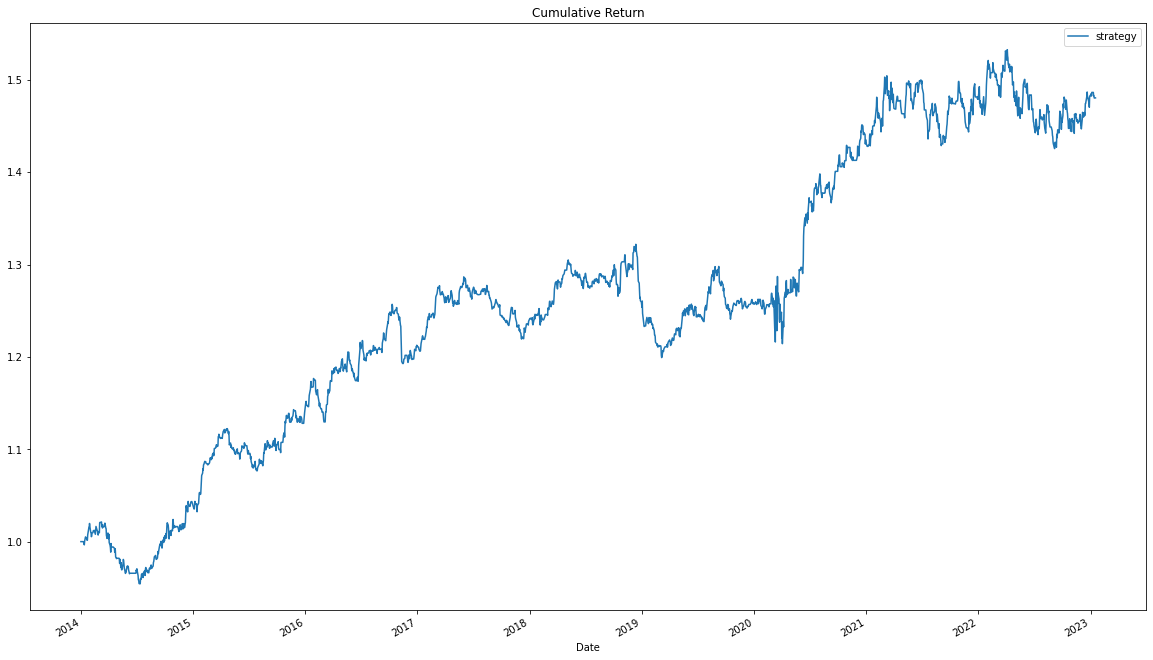

In [15]:
prices[['strategy']].loc['2014-01-02':].dropna().cumsum().apply(np.exp).plot(figsize=(20,12), title = 'Cumulative Return')

In [16]:
import pyfolio as pf

Start date,2017-02-01
End date,2023-01-17
Total months,71
,Backtest
Annual return,2.9%
Cumulative returns,18.5%
Annual volatility,6.8%
Sharpe ratio,0.45
Calmar ratio,0.31
Stability,0.71
Max drawdown,-9.3%


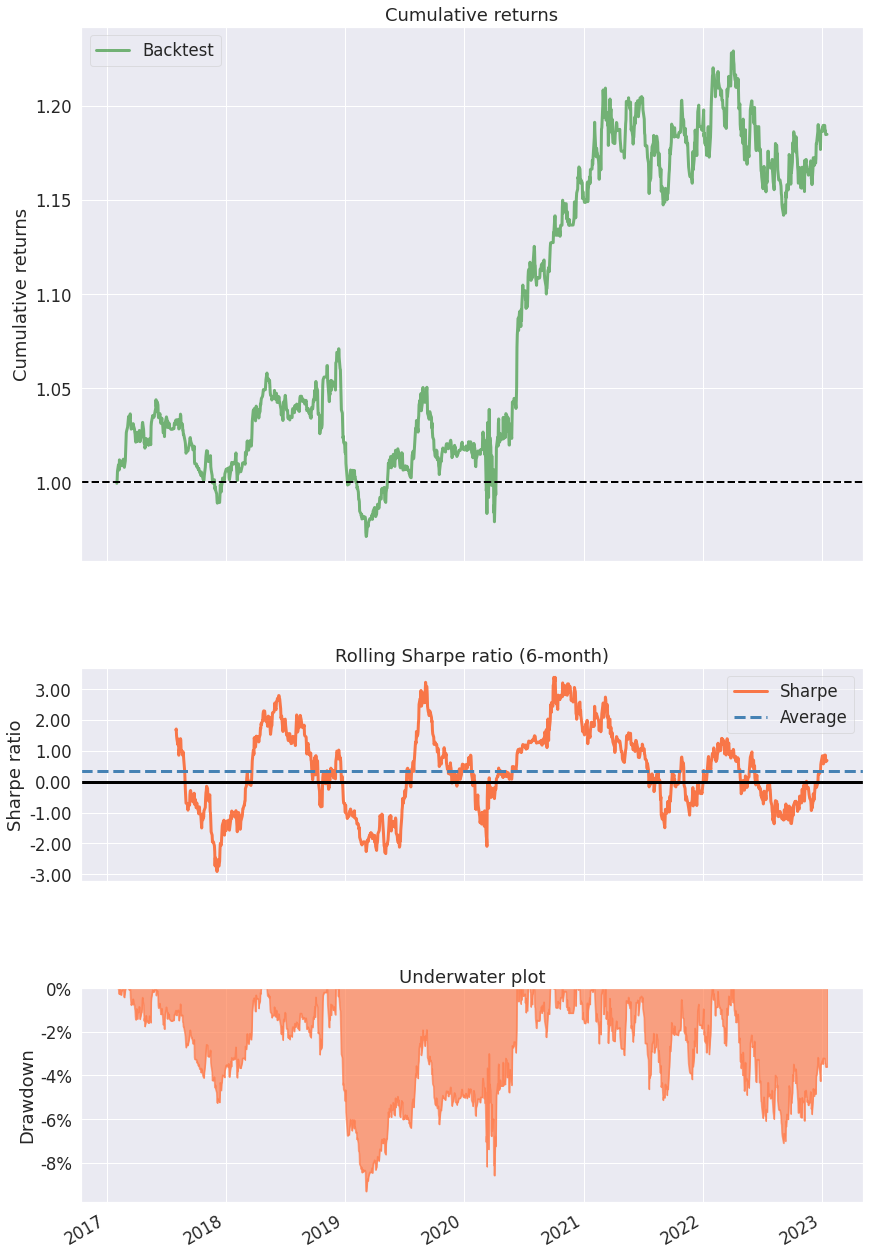

In [17]:
pf.create_simple_tear_sheet(prices['strategy'][-1500:])

In [18]:
Prices = prices['strategy'].loc['2014-01-02':].dropna().cumsum().apply(np.exp)


In [19]:
Prices = pd.DataFrame(Prices)

In [20]:
Prices

,strategy
Date,
2014-01-02,1.000000
2014-01-03,1.000000
2014-01-06,1.000000
2014-01-07,1.000000
2014-01-08,1.000000
...,...
2023-01-10,1.486378
2023-01-11,1.482792
2023-01-12,1.482792


In [21]:
Prices.index


DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-17'],
              dtype='datetime64[ns]', name='Date', length=2276, freq=None)

In [22]:
# Write to a csv file
Prices.to_csv('Prices.csv')

In [23]:
price_df = pd.read_excel('Prices.xlsx')

In [24]:
price_df

,Date,strategy,cum_ret
0,2014-01-02,1.000000,1.000000
1,2014-01-03,1.000000,1.000000
2,2014-01-06,1.000000,1.000000
3,2014-01-07,1.000000,1.000000
4,2014-01-08,1.000000,1.000000
...,...,...,...
2271,2023-01-10,1.486378,1.266384
2272,2023-01-11,1.482792,1.266384
2273,2023-01-12,1.482792,1.266384
2274,2023-01-13,1.480305,1.266384


In [25]:
price_df = price_df.set_index(price_df['Date'])
price_df

,Date,strategy,cum_ret
Date,,,
2014-01-02,2014-01-02,1.000000,1.000000
2014-01-03,2014-01-03,1.000000,1.000000
2014-01-06,2014-01-06,1.000000,1.000000
2014-01-07,2014-01-07,1.000000,1.000000
2014-01-08,2014-01-08,1.000000,1.000000
...,...,...,...
2023-01-10,2023-01-10,1.486378,1.266384
2023-01-11,2023-01-11,1.482792,1.266384
2023-01-12,2023-01-12,1.482792,1.266384


In [26]:
price = price_df[['strategy', 'cum_ret']]
price

,strategy,cum_ret
Date,,
2014-01-02,1.000000,1.000000
2014-01-03,1.000000,1.000000
2014-01-06,1.000000,1.000000
2014-01-07,1.000000,1.000000
2014-01-08,1.000000,1.000000
...,...,...
2023-01-10,1.486378,1.266384
2023-01-11,1.482792,1.266384
2023-01-12,1.482792,1.266384


In [27]:
price = price.rename(columns = {'strategy': 'Bol_Band', 'cum_ret': 'Copula'})

<AxesSubplot: title={'center': 'Cumulative Return'}, xlabel='Date'>

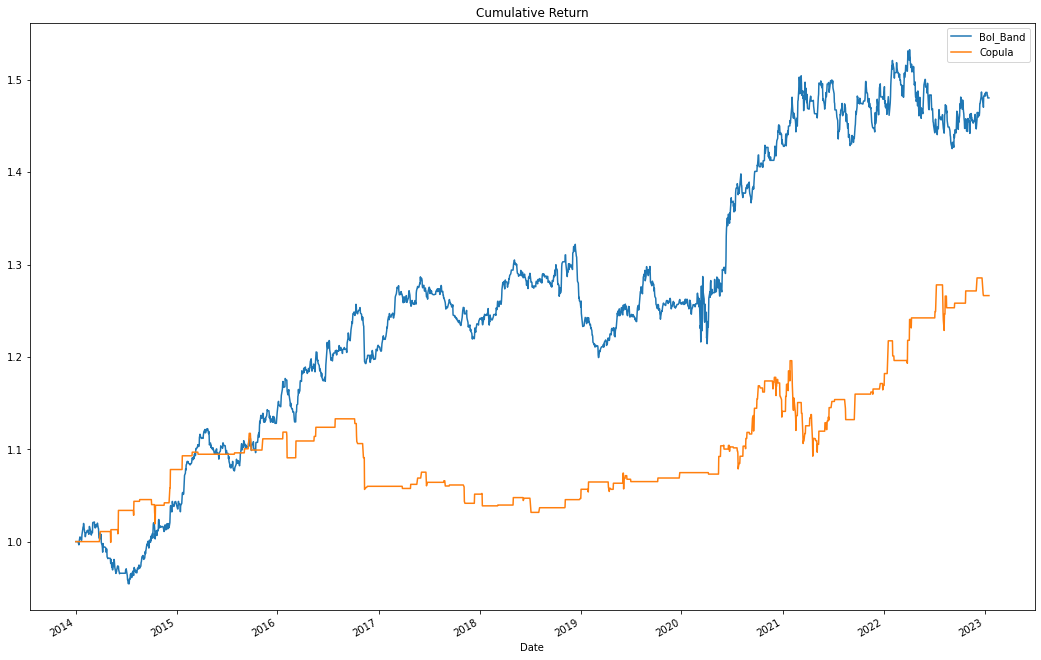

In [28]:
price[['Bol_Band', 'Copula']].plot(figsize=(18,12), title = 'Cumulative Return')

In [29]:
spy_price = yf.download('SPY', start='2013-12-31', end='2023-01-18')[['Close']]

[*********************100%***********************]  1 of 1 completed


In [30]:
spy_price

,Close
Date,
2013-12-31,184.690002
2014-01-02,182.919998
2014-01-03,182.889999
2014-01-06,182.360001
2014-01-07,183.479996
...,...
2023-01-10,390.579987
2023-01-11,395.519989
2023-01-12,396.959991


In [31]:
spy_ret = spy_price.pct_change().dropna()

In [32]:
spy_cum = np.nancumprod(spy_ret + 1)

In [33]:
spy_cum

array([0.99041635, 0.99025392, 0.98738426, ..., 2.14933124, 2.15766958,
       2.15371695])

In [34]:
price['SPY'] = spy_cum

In [35]:
price

,Bol_Band,Copula,SPY
Date,,,
2014-01-02,1.000000,1.000000,0.990416
2014-01-03,1.000000,1.000000,0.990254
2014-01-06,1.000000,1.000000,0.987384
2014-01-07,1.000000,1.000000,0.993448
2014-01-08,1.000000,1.000000,0.993665
...,...,...,...
2023-01-10,1.486378,1.266384,2.114787
2023-01-11,1.482792,1.266384,2.141534
2023-01-12,1.482792,1.266384,2.149331


<AxesSubplot: title={'center': 'Cumulative Return'}, xlabel='Date'>

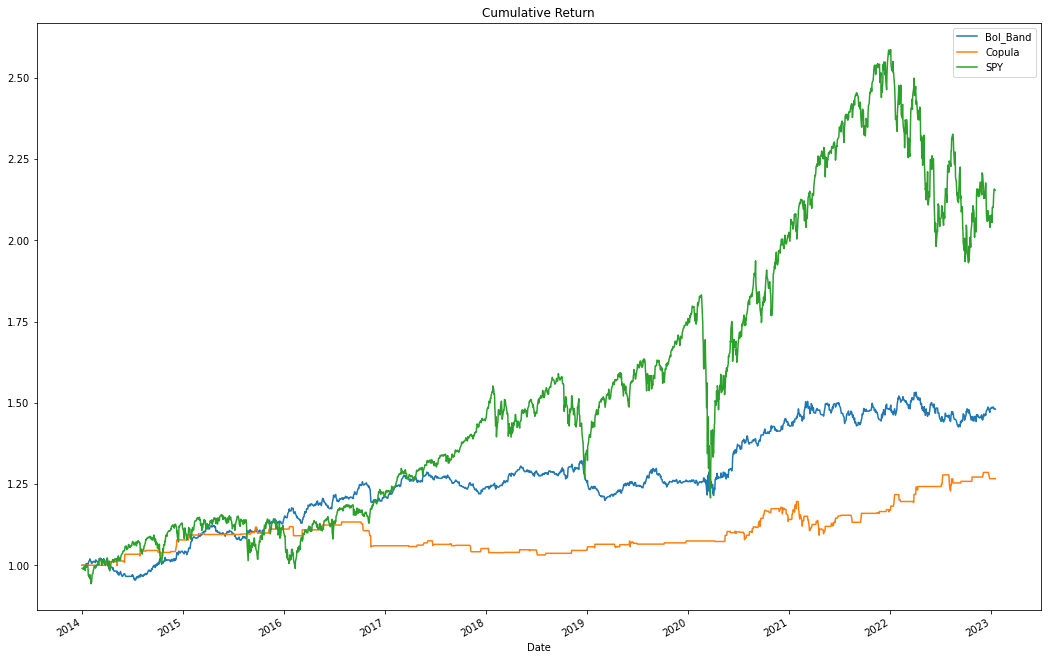

In [36]:
price[['Bol_Band', 'Copula', 'SPY']].plot(figsize=(18,12), title = 'Cumulative Return')